# Binary star evolution and binary black holes
A binary black hole (BBH) can originate from the evolution of a massive binary star. If the binary is tight enough, it will evolve through several complex physical processes: the two stars can exchange mass either via **stable mass transfer** or via a **common envelope**.

Mass transfer is mainly driven by Roche-lobe filling, as this process is usually more efficient than wind accretion. The Roche lobe of a star in a binary system is a teardrop-shaped equipotential surface surrounding the star. Mass transfer occurs when a star overfills its Roche lobe, i.e. when its radius becomes larger than the Roche lobe, and it changes:
- the mass of each star
- the final mass of the compact remnants
- orbital properties of the binary (e.g. the semi-major axis)

<div>
<img src="Roche_lobe_overflow.jpg" width="700"/>
</div>

If mass transfer becomes unstable (e.g. both stars fill Roche lobe), the two stars enter a Common Envelope (CE) phase: the binary system is embedded in a gaseous, non-corotating envelope and the two members spiral in due to the gas drag exerted by the envelope. Part of the orbital energy lost as an effect of this drag is likely converted into heating of the envelope, making it more loosely bound, and this process can lead to the ejection of the envelope.

<div>
<img src="common_envelope.png" width="700"/>
</div>

To describe a common envelope, the most common formalism is the $\alpha$ formalism, where $\alpha$ is a dimensionless parameter that measures the fraction of the removed orbital energy that is transferred to the envelope, so the efficiency with which the CE is expelled. A large alpha means that the envelope is easily ejected, while a small alpha means that it takes a lot of energy to be expelled.

The simulated system can have an apparently unphysical value of $\alpha>1$, due to the fact that this simple formalism poorly describes the physics of CE, so in a full discussion the orbital energy is only one of the energy sources that partecipate in the envelope ejection.


## Goal of the project
Understand the differences between binary black hole mergers whose progenitors evolved via common envelope and binary black hole mergers whose progenitors evolved via stable mass transfer, by looking at a set of simulated binary black holes.

## Datasets 

Datasets are stored on Google Drive at this [link](https://drive.google.com/drive/folders/1RZGrL6RrKYKaPu0VJ7BQDXptb7B_QOLg). The tar file stable_MT_vs_CE.tgz contains 4 folders (A0.5, A1, A3 and A5). Each of them corresponds to the outputs of a set of simulations of binary black holes, which differ only by one parameter: the value of the parameter $\alpha$ ($\alpha$=0.5,1,3,5) associated with the efficiency of common envelope.

Inside each folder, there are 12 files, named MTCE_BBHs_*.txt, where * is a number ranging from 0.0002 to 0.02 and represents the stellar metallicity at which the black holes where produced in the simulations.

Each row contains the properties of one simulated binary black hole. The most important columns (properties) for this analysis are:
- Column 1: initial mass (ZAMS mass) of the primary member of the binary system in Msun
- Column 2: initial mass (ZAMS mass) of the secondary member of the binary system in Msun
- Column 3: mass of the black hole that forms from the primary member (Msun)
- Column 4: mass of the black hole that forms from the secondary member (Msun)
- Column 6: delay time, i.e. time elapsed from the formation of the binary system to the merger of the two black holes (in Myr)
- Column 7: semi-major axis of the binary system at the formation of the second-born black hole (in solar radii, Rsun = 6.95e10 cm)
- Column 8: orbital eccentricity of the binary system at the formation of the second-born black hole
- **Column 21: Boolean variable indicating whether the binary system undergoes a common envelope (True). If column 21 is False, the binary goes via stable mass transfer instead of a common envelope.**

We then added 4 extra columns to the dataframe: 
- Metallicity
- Alpha ($\alpha$)
- Column Extra 1: inital mass ratio (ZAMS mass of the primary / ZAMS mass of the secondary)
- Column Extra 2: mass ratio of the black holes (mass of the BH that forms from the primary / mass of the BH that forms from the secondary)


## Creation of the dataframe

In [1]:
import pandas as pd
import numpy as np
import string
import glob
import os
import seaborn as sns
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy import linalg as la
from IPython.display import display
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

In [45]:
# personalized computer settings

hname = os.getlogin()
path = ''

if hname=='paolozinesi': path = '/Users/paolozinesi/Downloads/Project_LCP_A/stable_MT_vs_CE/'
if hname=='tommaso': path = "/Users/tommaso/Desktop/MagistraleI/TheFormationOfBinaryBlackHoles_data/lab_data/stable_MT_vs_CE/"
if hname=='Nicola': path = "/Users/Nicola/data/TheFormationOfBinaryBlackHoles_data/stable_MT_vs_CE/"
if hname=='ilazza': path = "/home/ilazza/Documenti/UNIPD/TheFormationOfBinaryBlackHoles/stable_MT_vs_CE/"

In [46]:
alpha_values = [0.5, 1, 3, 5]
met_values = [0.02, 0.002, 0.0002, 0.004, 0.0004, 0.006, 0.008, 0.012, 0.0012, 0.016, 0.0016]
columns=['col.0:ID','col.1:m1ZAMS/Msun', 'col.2:m2ZAMS/Msun', 'col.3:m1rem/Msun','col.4:m2rem/Msun',  'col.6:delay_time/Myr', 'col.7:sma/Rsun', 'col.8:ecc', 'col.21:CE']
frame = pd.DataFrame(data=None, columns=columns)

for alpha in alpha_values:
    for met in met_values:
        for name in glob.glob(path+f'A{alpha}/MTCE_BBHs_{met}*'):
            df = pd.read_csv(name, skiprows=2, header=0, sep=' ')
            df = df.loc[:,columns]
            met_array = np.ones((df.shape[0], 1))*met
            alpha_array = np.ones((df.shape[0],1))*alpha
            df['metallicity'] = met_array
            df['alpha'] = alpha_array
            
            frame = pd.concat([frame, df], axis=0, ignore_index=True)
            
frame['colExt1:ratio_m1_m2_ZAMS'] = frame['col.1:m1ZAMS/Msun']/frame['col.2:m2ZAMS/Msun']
frame['colExt2:ratio_m1_m2_rem'] = frame['col.3:m1rem/Msun']/frame['col.4:m2rem/Msun']


In [47]:
frame.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha,colExt1:ratio_m1_m2_ZAMS,colExt2:ratio_m1_m2_rem
0,0_6942,50.9151,50.8356,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5,1.001564,1.011016
1,0_80347,57.0253,56.9464,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5,1.001386,1.009471
2,0_158611,91.0594,90.7083,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5,1.003871,1.014076
3,0_211410,117.9396,57.6917,19.3984,11.2422,7905.6343,11229.0000,0.999640,False,0.02,0.5,2.044308,1.725499
4,0_213101,40.2965,40.2439,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5,1.001307,1.008970


In [48]:
#Creating the a dataframe with common envelopes and one with mass transfer
frame_true = frame[(frame['col.21:CE'] == True)] 
frame_true = frame_true.reset_index(drop=True)
frame_false = frame[(frame['col.21:CE'] == False)] 
frame_false = frame_false.reset_index(drop=True)

In [49]:
frame_true.head()



,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha,colExt1:ratio_m1_m2_ZAMS,colExt2:ratio_m1_m2_rem
0,0_6942,50.9151,50.8356,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5,1.001564,1.011016
1,0_80347,57.0253,56.9464,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5,1.001386,1.009471
2,0_158611,91.0594,90.7083,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5,1.003871,1.014076
3,0_213101,40.2965,40.2439,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5,1.001307,1.008970
4,0_261642,62.6781,58.8130,7.5024,5.9658,2895.4182,10.4610,0.163210,True,0.02,0.5,1.065718,1.257568


In [50]:
frame_false.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha,colExt1:ratio_m1_m2_ZAMS,colExt2:ratio_m1_m2_rem
0,0_211410,117.9396,57.6917,19.3984,11.2422,7905.6343,11229.000,0.999640,False,0.020,0.5,2.044308,1.725499
1,1_3370919,76.2366,38.3205,10.0905,8.1532,5914.8696,5378.200,0.999510,False,0.020,0.5,1.989447,1.237612
2,1_3601930,123.0264,39.9761,18.0234,7.6028,9398.3252,3408.700,0.998740,False,0.020,0.5,3.077499,2.370627
3,3_2982857,132.6673,30.7234,20.7397,5.6742,3331.2690,3755.500,0.999260,False,0.020,0.5,4.318119,3.655088
4,0_526,75.1587,33.6683,26.1035,25.6875,12982.4980,41.214,0.009654,False,0.002,0.5,2.232328,1.016195


In [51]:
#frame_graph = frame.drop(columns=['col.0:ID'], axis=1)
#sns.pairplot(frame, hue = 'col.21:CE', palette='Set2')

In [52]:
#frame_graph.head()

In [53]:



#frame_graph = frame.drop(columns=['col.0:ID', 'metallicity', 'alpha'], axis=1)
#sns.pairplot(frame_graph, hue = 'col.21:CE', palette='Set2')
                    

## ML algorithms

In [54]:
# create training and test set
m_train = 20000
m_test = 1000

frame_sample = pd.concat([frame_true.sample(n=int(0.5*(m_train+m_test))),
                          frame_false.sample(n=int(0.5*(m_train+m_test)))], ignore_index=True)

frame_sample = frame_sample.sample(frac=1, ignore_index=True)
frame_train = frame_sample.iloc[:m_train]
frame_test = frame_sample.iloc[-m_test:]

# separate dataframes
lbl = {False:'SMT', True:'CE'}
X_train = frame_train.drop(labels=["col.0:ID","col.21:CE"], axis=1)
Y_train = frame_train["col.21:CE"].apply(lambda x: lbl[x])
X_test = frame_test.drop(labels=["col.0:ID","col.21:CE"], axis=1)
Y_test = frame_test["col.21:CE"].apply(lambda x: lbl[x])

### PCA

In [55]:
# DATA NORMALIZATION
# standardize the input matrix
from sklearn import preprocessing
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_train)

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
pd.set_option("chop_threshold", 1e-08)

X_train_ = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
df_tmp = pd.DataFrame(np.around(pd.concat([X_train_.mean(axis=0), X_train_.std(axis=0)], axis=1), 3))
df_tmp.columns = ['mean','std']
print ("\nMean and std of the training input data:", )
display(df_tmp)

X_test_ = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns) # use the same transformation on test data
# df_tmp = pd.DataFrame(np.around(pd.concat([X_test_.mean(axis=0), X_test_.std(axis=0)], axis=1), 3))
# df_tmp.columns = ['mean','std']
# print ("\nMean and std of the test input data:", )
# display(df_tmp)

# PCA
data_PCA = X_train_.values.T
# eigenvectors and eigenvalues using SVD
U, spectrum, Vt = la.svd(data_PCA)
V = U                          # eigenvectors matrix
l = spectrum**2/(m_train-1)    # eigenvalues
np.set_printoptions(precision=3)
print('\nEigenvalues: \n', l)
# print('Eigenvectors:\n', V_svd)

ncomp = 8
variability_PC = np.sum(l[:ncomp])/np.sum(l)
print('\nPercent of the total variability explained by the %.0f principal components: %.5f' %(ncomp, variability_PC))


Mean and std of the training input data:


,mean,std
col.1:m1ZAMS/Msun,0.0,1.0
col.2:m2ZAMS/Msun,0.0,1.0
col.3:m1rem/Msun,0.0,1.0
col.4:m2rem/Msun,0.0,1.0
col.6:delay_time/Myr,0.0,1.0
col.7:sma/Rsun,0.0,1.0
col.8:ecc,0.0,1.0
metallicity,0.0,1.0
alpha,0.0,1.0
colExt1:ratio_m1_m2_ZAMS,0.0,1.0



Eigenvalues: 
 [3.884 1.804 1.177 1.049 0.927 0.896 0.676 0.473 0.068 0.037 0.009]

Percent of the total variability explained by the 8 principal components: 0.98961


,0,1,2,3,4,5,6,7,col.21:CE
0,-0.768867,1.262833,0.307351,0.321205,1.556714,0.881066,-1.253322,-0.085242,SMT
1,0.324844,0.614296,-0.59553,0.580174,-1.631105,0.24181,-0.437157,0.395702,SMT
2,0.804382,-0.493482,0.16455,0.309284,-1.029778,0.113369,0.226215,-0.289334,CE
3,-0.911578,1.330355,-0.869858,0.403561,-0.93374,0.167825,-0.405321,0.331017,SMT
4,-2.047509,-0.335444,-0.794082,0.000573,0.938465,0.316982,-0.315046,0.01849,SMT


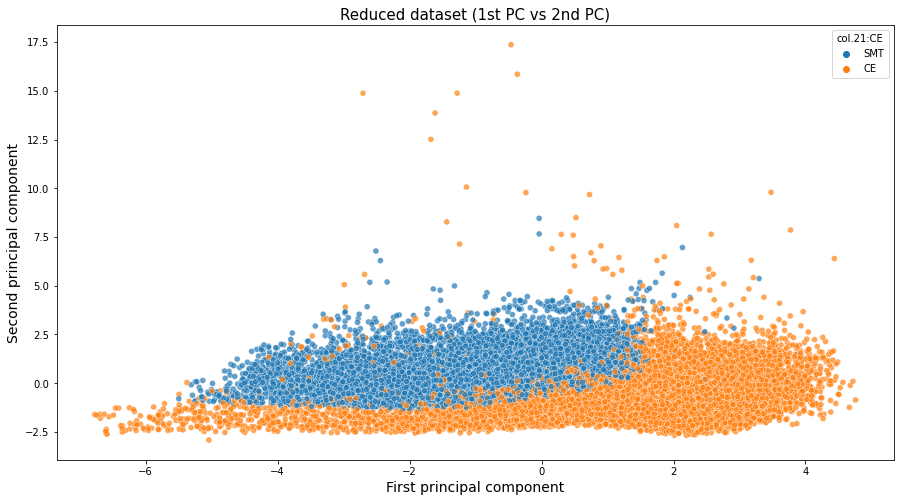

In [56]:
# Data in the PCA basis
data_ = np.dot(V.T, data_PCA)

# Reduce the dimensionality of the dataset 
data_reduced = data_[:ncomp,:] 

X_train_PCA = pd.DataFrame(data_reduced.T)
X_test_PCA = pd.DataFrame(np.dot(V.T, X_test_.T)[:ncomp,:].T)
# print(X_train_PCA.shape)
# print(X_test_PCA.shape)

df = pd.DataFrame(np.column_stack((X_train_PCA, Y_train)))
df.rename(columns = {ncomp:'col.21:CE'}, inplace=True)
display(df.head())

plt.figure(figsize=(15, 8))
sns.scatterplot(x=0, y=1, hue='col.21:CE', data=df, alpha=0.7)
plt.xlabel('First principal component', fontsize=14)
plt.ylabel('Second principal component', fontsize=14)
plt.title('Reduced dataset (1st PC vs 2nd PC)', fontsize=15)
plt.show()

### Random Forest: no smoothing, no normalization of data

In [57]:
RF_clf = RandomForestClassifier(max_depth=None)
RF_clf.fit(X_train, Y_train)

train_err = 1 - RF_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)
test_err = 1 - RF_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([RF_clf.feature_names_in_, RF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.000
Test error = 0.011


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.263132
10,colExt2:ratio_m1_m2_rem,0.204402
0,col.1:m1ZAMS/Msun,0.127228
2,col.3:m1rem/Msun,0.12573
5,col.7:sma/Rsun,0.105552
3,col.4:m2rem/Msun,0.047699
6,col.8:ecc,0.046583
1,col.2:m2ZAMS/Msun,0.035603
4,col.6:delay_time/Myr,0.028627
7,metallicity,0.010776


In [58]:
# Export as dot file
export_graphviz(RF_clf.estimators_[50], out_file='RF.dot', 
                feature_names = RF_clf.feature_names_in_,
                class_names = RF_clf.classes_,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

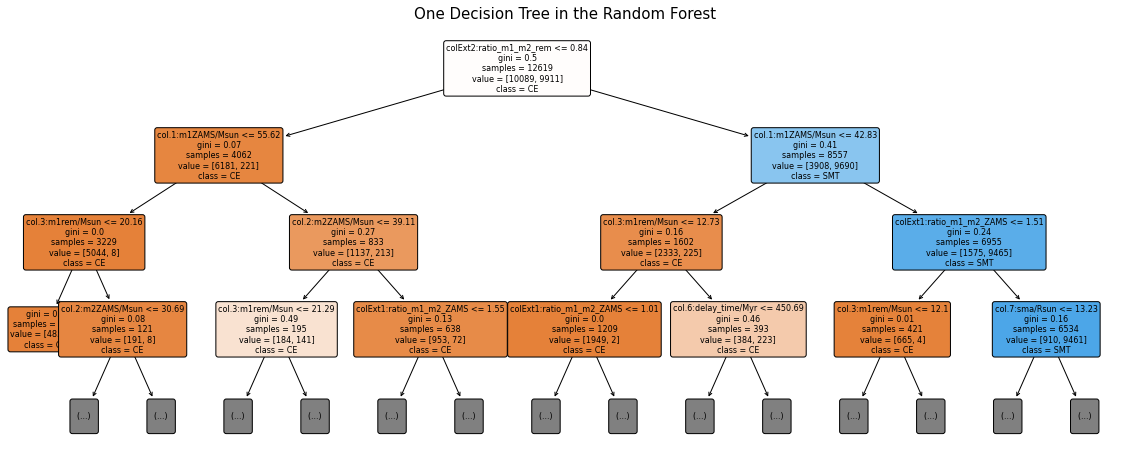

In [59]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(RF_clf.estimators_[50], max_depth=3,
                        feature_names = RF_clf.feature_names_in_,
                        class_names = RF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize=8, ax=ax)
ax.set_title('One Decision Tree in the Random Forest', fontsize=15)
plt.show()

### Random Forest: no smoothing, with normalization of data

In [60]:
normRF_clf = RandomForestClassifier(max_depth=None)
normRF_clf.fit(X_train_, Y_train)

train_err = 1 - normRF_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)
test_err = 1 - normRF_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([normRF_clf.feature_names_in_, normRF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.000
Test error = 0.012


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.271991
10,colExt2:ratio_m1_m2_rem,0.183592
0,col.1:m1ZAMS/Msun,0.139397
2,col.3:m1rem/Msun,0.121015
5,col.7:sma/Rsun,0.108841
3,col.4:m2rem/Msun,0.054086
1,col.2:m2ZAMS/Msun,0.039444
6,col.8:ecc,0.036816
4,col.6:delay_time/Myr,0.029655
7,metallicity,0.011056


In [61]:
# Export as dot file
export_graphviz(normRF_clf.estimators_[50], out_file='normRF.dot', 
                feature_names = normRF_clf.feature_names_in_,
                class_names = str(normRF_clf.classes_),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

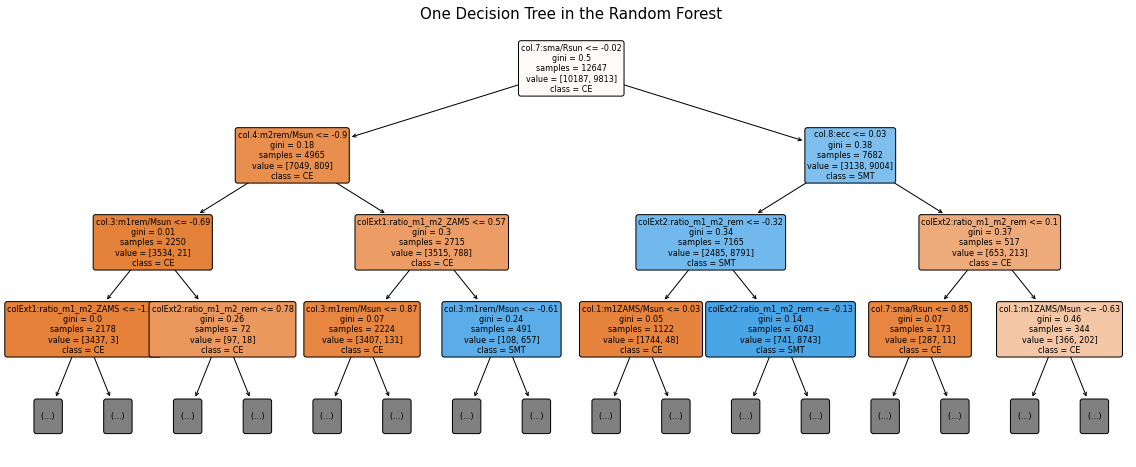

In [62]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(normRF_clf.estimators_[50], max_depth=3,
                        feature_names = normRF_clf.feature_names_in_,
                        class_names = normRF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize=8, ax=ax);
ax.set_title('One Decision Tree in the Random Forest', fontsize=15)
plt.show()

### Random Forest: with smoothing, with normalization of data

In [63]:
# cross validation
parameters = {'max_depth':[3,5,7], 'min_samples_leaf':[1e-05,1e-04,1e-03,1e-02]}
cvres = GridSearchCV(RandomForestClassifier(), parameters)
cvres.fit(X_train_, Y_train)
display(pd.DataFrame.from_dict(cvres.cv_results_))
smooth_normRF_clf = cvres.best_estimator_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.261592,0.230414,0.076554,0.022283,3,0.00001,"{'max_depth': 3, 'min_samples_leaf': 1e-05}",0.96925,0.95500,0.96300,0.96325,0.96000,0.96210,0.004649,10
1,2.000417,0.333138,0.059656,0.027706,3,0.0001,"{'max_depth': 3, 'min_samples_leaf': 0.0001}",0.96600,0.96150,0.96100,0.96500,0.95825,0.96235,0.002818,9
2,2.410425,0.615496,0.082105,0.012152,3,0.001,"{'max_depth': 3, 'min_samples_leaf': 0.001}",0.96775,0.96175,0.95975,0.95825,0.95900,0.96130,0.003429,11
3,2.873596,0.192283,0.113039,0.016464,3,0.01,"{'max_depth': 3, 'min_samples_leaf': 0.01}",0.96875,0.96200,0.95475,0.95800,0.96075,0.96085,0.004671,12
4,3.480332,0.432116,0.092668,0.019764,5,0.00001,"{'max_depth': 5, 'min_samples_leaf': 1e-05}",0.97700,0.97175,0.97250,0.97500,0.97175,0.97360,0.002077,5
5,3.622381,0.716111,0.085522,0.023417,5,0.0001,"{'max_depth': 5, 'min_samples_leaf': 0.0001}",0.97550,0.97425,0.97575,0.97600,0.96950,0.97420,0.002426,4
6,3.484881,0.600680,0.088789,0.021026,5,0.001,"{'max_depth': 5, 'min_samples_leaf': 0.001}",0.97575,0.97225,0.97375,0.97450,0.97050,0.97335,0.001821,6
7,2.445679,0.167012,0.085951,0.008048,5,0.01,"{'max_depth': 5, 'min_samples_leaf': 0.01}",0.97150,0.96525,0.96900,0.96775,0.96275,0.96725,0.003021,8
8,3.767842,1.041888,0.080237,0.034818,7,0.00001,"{'max_depth': 7, 'min_samples_leaf': 1e-05}",0.98250,0.98125,0.98100,0.98325,0.97850,0.98130,0.001623,2
9,4.089802,0.627246,0.089146,0.038341,7,0.0001,"{'max_depth': 7, 'min_samples_leaf': 0.0001}",0.98325,0.98050,0.98125,0.98300,0.97925,0.98145,0.001512,1


In [64]:
train_err = 1 - smooth_normRF_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)
test_err = 1 - smooth_normRF_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([smooth_normRF_clf.feature_names_in_, smooth_normRF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.016
Test error = 0.019


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.274252
10,colExt2:ratio_m1_m2_rem,0.211496
2,col.3:m1rem/Msun,0.13004
5,col.7:sma/Rsun,0.11486
0,col.1:m1ZAMS/Msun,0.10181
3,col.4:m2rem/Msun,0.064541
6,col.8:ecc,0.03716
1,col.2:m2ZAMS/Msun,0.02933
4,col.6:delay_time/Myr,0.028973
7,metallicity,0.004602


In [65]:
# Export as dot file
export_graphviz(smooth_normRF_clf.estimators_[50], out_file='smooth_normRF.dot', 
                feature_names = smooth_normRF_clf.feature_names_in_,
                class_names = str(smooth_normRF_clf.classes_),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

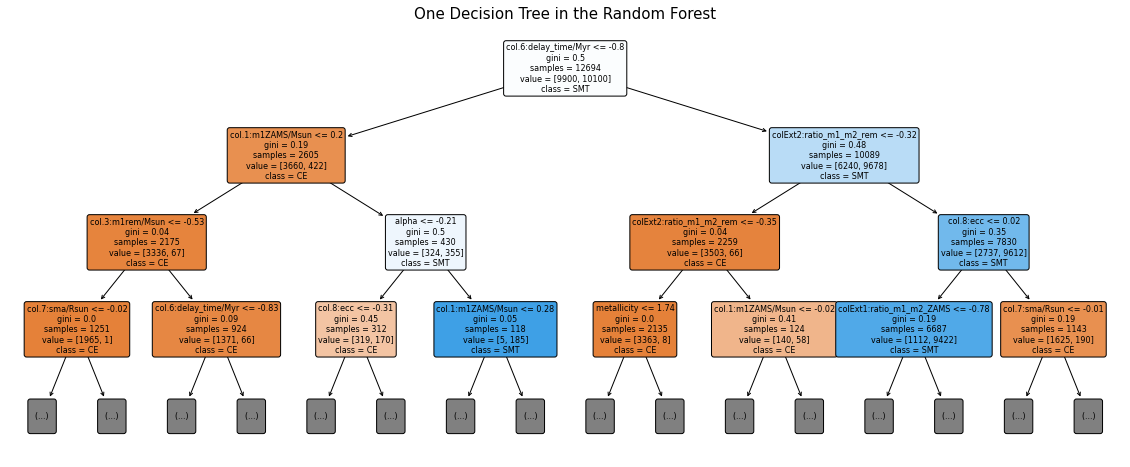

In [66]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(smooth_normRF_clf.estimators_[50], max_depth=3,
                        feature_names = smooth_normRF_clf.feature_names_in_,
                        class_names = smooth_normRF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize=8, ax=ax)

ax.set_title('One Decision Tree in the Random Forest', fontsize=15)
plt.show()

### SVM

In [67]:
SVM_clf = sklearn.svm.SVC()
SVM_clf.fit(X_train, Y_train)

train_err = 1 - SVM_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - SVM_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

Training error = 0.282
Test error = 0.271


## Graphs
### Initial and final masses of the members

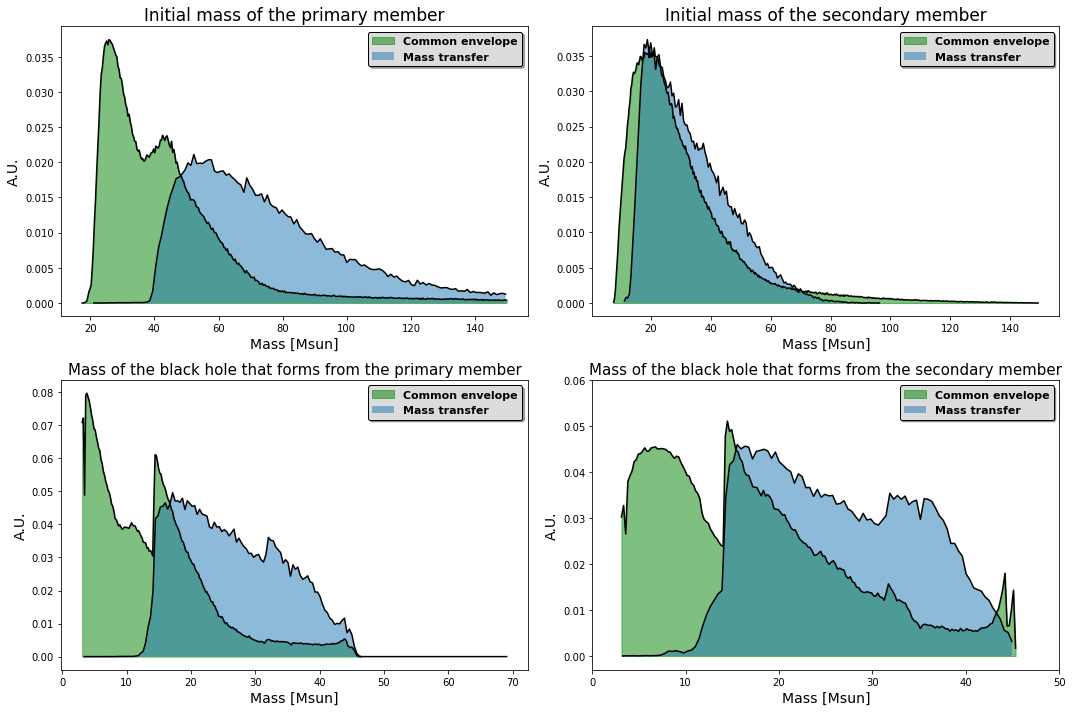

In [74]:
fig, ax = plt.subplots(nrows= 2, ncols=2, figsize=(15, 10))



#[0,0]  -   col.1:m1ZAMS/Msun - col.21:CE   - Initial mass of the primary member per Formation Process

entries_1_t, edges_1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.1:m1ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_1_f, edges_1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.1:m1ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0,0].plot(bin_centers_1_t, entries_1_t, color='black')
ax[0,0].fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0,0].plot(bin_centers_1_f, entries_1_f, color='black')
ax[0,0].fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')

ax[0,0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0,0].set_title('Initial mass of the primary member', fontsize=17)
ax[0,0].set_xlabel('Mass [Msun]', fontsize=14)
ax[0,0].set_ylabel('A.U.', fontsize=14)                 #legend & titles



#[0,1]  -   col.2:m2ZAMS/Msun - col.21:CE   - Initial mass of the secondary member per Formation Process

entries_2_t, edges_2_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.2:m2ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_2_t = 0.5 * (edges_2_t[:-1] + edges_2_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_2_f, edges_2_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.2:m2ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_2_f = 0.5 * (edges_2_f[:-1] + edges_2_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[0,1].plot(bin_centers_2_t, entries_2_t, color='black')
ax[0,1].fill_between(bin_centers_2_t, entries_2_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0,1].plot(bin_centers_2_f, entries_2_f, color='black')
ax[0,1].fill_between(bin_centers_2_f, entries_2_f, alpha=0.5, label = 'Mass transfer')

ax[0,1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0,1].set_title('Initial mass of the secondary member', fontsize=17)
ax[0,1].set_xlabel('Mass [Msun]', fontsize=14)
ax[0,1].set_ylabel('A.U.', fontsize=14)             #legend & titles



#[1,0]  -   col.3:m1rem/Msun - col.21:CE   - BlackHole mass from the primary member per Formation Process

entries_3_t, edges_3_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.3:m1rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_3_t = 0.5 * (edges_3_t[:-1] + edges_3_t[1:])    #Norm Hist for TRUE - CommonEnvelope

entries_3_f, edges_3_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.3:m1rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_3_f = 0.5 * (edges_3_f[:-1] + edges_3_f[1:])    #Norm Hist for FALSE - StableMassTransfer

ax[1,0].plot(bin_centers_3_t, entries_3_t, color='black')
ax[1,0].fill_between(bin_centers_3_t, entries_3_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1,0].plot(bin_centers_3_f, entries_3_f, color='black')
ax[1,0].fill_between(bin_centers_3_f, entries_3_f, alpha=0.5, label = 'Mass transfer')

ax[1,0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1,0].set_title('Mass of the black hole that forms from the primary member', fontsize=15)
ax[1,0].set_xlabel('Mass [Msun]', fontsize=14)
ax[1,0].set_ylabel('A.U.', fontsize=14)           #legend & titles



#[1,1]  -   col.4:m2rem/Msun - col.21:CE   - BlackHole mass from the secondary member per Formation Process


entries_4_t, edges_4_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.4:m2rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_4_t = 0.5 * (edges_4_t[:-1] + edges_4_t[1:])          #Norm Hist for TRUE - CommonEnvelope

entries_4_f, edges_4_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.4:m2rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_4_f = 0.5 * (edges_4_f[:-1] + edges_4_f[1:])          #Norm Hist for FALSE - StableMassTransfer

ax[1,1].plot(bin_centers_4_t, entries_4_t, color='black')
ax[1,1].fill_between(bin_centers_4_t, entries_4_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1,1].plot(bin_centers_4_f, entries_4_f, color='black')
ax[1,1].fill_between(bin_centers_4_f, entries_4_f, alpha=0.5, label = 'Mass transfer')

ax[1,1].set_xlim(right=50, left= 0)
ax[1,1].set_ylim(bottom=-0.003, top=0.06)
ax[1,1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1,1].set_title('Mass of the black hole that forms from the secondary member', fontsize=15)
ax[1,1].set_xlabel('Mass [Msun]', fontsize=14)
ax[1,1].set_ylabel('A.U.', fontsize=14)                #legend & titles
  


fig.tight_layout()

### Time elapsed, sma, eccentricity

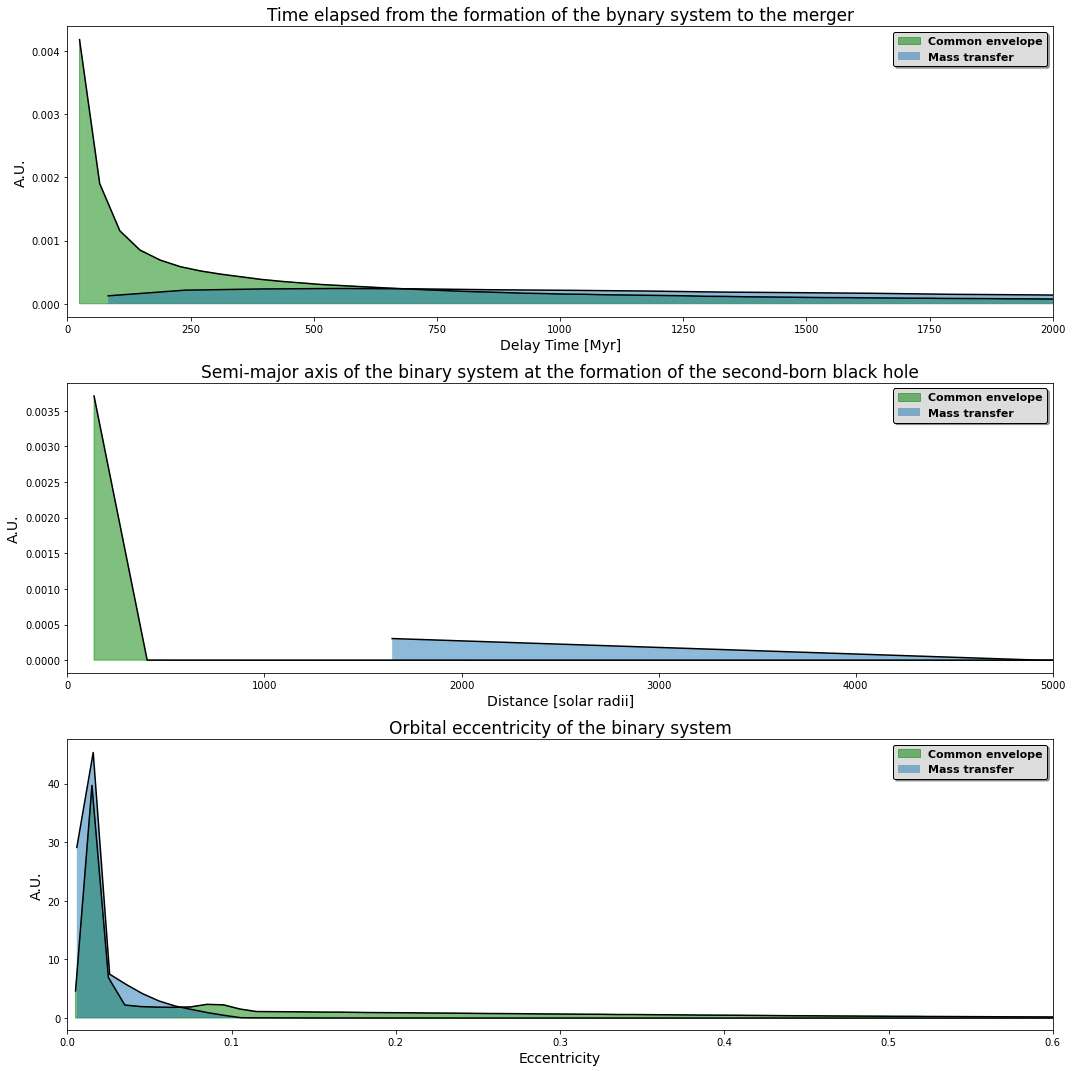

In [78]:
fig, ax = plt.subplots(nrows= 3, ncols=1, figsize=(15, 15))



#[0]  -   col.6:delay_time/Myr - col.21:CE   - Delay Time per Formation Process

entries_dt_t, edges_dt_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.6:delay_time/Myr'], bins = 'fd', color = 'w', density=True)
bin_centers_dt_t = 0.5 * (edges_dt_t[:-1] + edges_dt_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_dt_f, edges_dt_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.6:delay_time/Myr'], bins = 'fd', color = 'w', density=True)
bin_centers_dt_f = 0.5 * (edges_dt_f[:-1] + edges_dt_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_dt_t, entries_dt_t, color='black')
ax[0].fill_between(bin_centers_dt_t, entries_dt_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_dt_f, entries_dt_f, color='black')
ax[0].fill_between(bin_centers_dt_f, entries_dt_f, alpha=0.5, label = 'Mass transfer')


ax[0].set_xlim(right=2000, left= 0)
ax[0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_title('Time elapsed from the formation of the bynary system to the merger', fontsize=17)
ax[0].set_xlabel('Delay Time [Myr]', fontsize=14)
ax[0].set_ylabel('A.U.', fontsize=14)                 #legend & titles



#[1]  -   col.7:sma/Rsun - col.21:CE   - Semi-major axis of the binary system per Formation Process

entries_sma_t, edges_sma_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.7:sma/Rsun'], bins = 100, color = 'w', density=True)
bin_centers_sma_t = 0.5 * (edges_sma_t[:-1] + edges_sma_t[1:])      # Hist for TRUE - CommonEnvelope 

entries_sma_f, edges_sma_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.7:sma/Rsun'], bins = 100, color = 'w', density=True)
bin_centers_sma_f = 0.5 * (edges_sma_f[:-1] + edges_sma_f[1:])      #Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_sma_t, entries_sma_t, color='black')
ax[1].fill_between(bin_centers_sma_t, entries_sma_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_sma_f, entries_sma_f, color='black')
ax[1].fill_between(bin_centers_sma_f, entries_sma_f, alpha=0.5, label = 'Mass transfer')

ax[1].set_xlim(left= 0, right = 5000)

ax[1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_title('Semi-major axis of the binary system at the formation of the second-born black hole', fontsize=17)
ax[1].set_xlabel('Distance [solar radii]', fontsize=14)
ax[1].set_ylabel('A.U.', fontsize=14)             #legend & titles



#[2]  -   col.8:ecc - col.21:CE   - Orbital eccentricity of the binary system vs Formation Process

entries_ecc_t, edges_ecc_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.8:ecc'], bins = 100, color = 'w', density=True)
bin_centers_ecc_t = 0.5 * (edges_ecc_t[:-1] + edges_ecc_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_ecc_f, edges_ecc_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.8:ecc'], bins = 100, color = 'w', density=True)
bin_centers_ecc_f = 0.5 * (edges_ecc_f[:-1] + edges_ecc_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[2].plot(bin_centers_ecc_t, entries_ecc_t, color='black')
ax[2].fill_between(bin_centers_ecc_t, entries_ecc_t, alpha=0.5, color='green', label = 'Common envelope')

ax[2].plot(bin_centers_ecc_f, entries_ecc_f, color='black')
ax[2].fill_between(bin_centers_ecc_f, entries_ecc_f, alpha=0.5, label = 'Mass transfer')


ax[2].set_xlim(right=0.6, left=0)
ax[2].set_ylim(bottom=-2)
ax[2].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[2].set_title('Orbital eccentricity of the binary system', fontsize=17)
ax[2].set_xlabel('Eccentricity', fontsize=14)
ax[2].set_ylabel('A.U.', fontsize=14)             #legend & titles


fig.tight_layout()

From this plot we can see that the semi-major axis of the binary system at the formation of the second-born black hole is truly different between the two formation processes and there is a clear separation between the two cases. Indeed, the value of this parameter is smaller when the system undergoes a Common Envelope with respect to when it evolves via Stable Mass Transfer.  
We believe that this difference is related to the Common Envelope process, during which the two members of the binary system reduce their mutual distance by spiraling in the gaseous environment. As an effect of the spiral in, after the CE we expect an orbital separation of the two objects much smaller than the initial one.

This separation is also useful for the Random Forest algorithm, in the sense that is a good discriminant for splitting and analyzing the data.

### Mass ratio

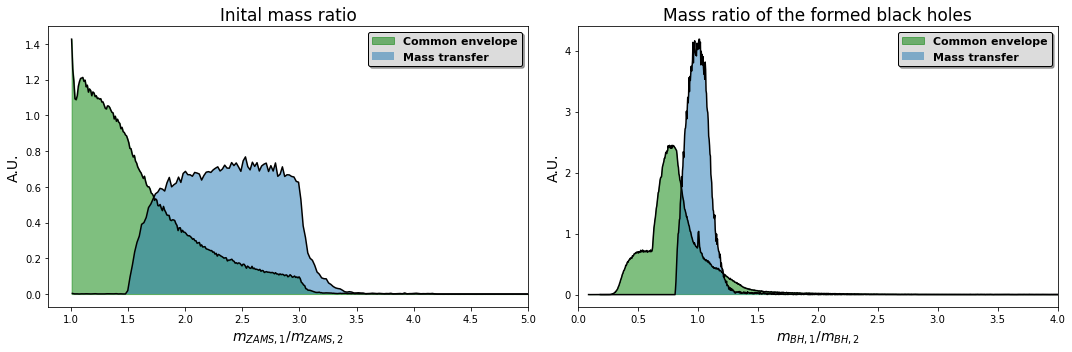

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))



#[0]  -   col.1:m1ZAMS/Msun - col.21:CE   - Initial mass of the primary member per Formation Process

entries_1_t, edges_1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_1_f, edges_1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_1_t, entries_1_t, color='black')
ax[0].fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_1_f, entries_1_f, color='black')
ax[0].fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')

ax[0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_title('Inital mass ratio', fontsize=17)
ax[0].set_xlabel(r'$m_{ZAMS, 1}/m_{ZAMS, 2}$', fontsize=14)
ax[0].set_ylabel('A.U.', fontsize=14)                 #legend & titles

ax[0].set_xlim(left=0.8,right=5)



#[1]  -   col.2:m2ZAMS/Msun - col.21:CE   - Initial mass of the secondary member per Formation Process

entries_2_t, edges_2_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_2_t = 0.5 * (edges_2_t[:-1] + edges_2_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_2_f, edges_2_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_2_f = 0.5 * (edges_2_f[:-1] + edges_2_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_2_t, entries_2_t, color='black')
ax[1].fill_between(bin_centers_2_t, entries_2_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_2_f, entries_2_f, color='black')
ax[1].fill_between(bin_centers_2_f, entries_2_f, alpha=0.5, label = 'Mass transfer')

ax[1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_title('Mass ratio of the formed black holes', fontsize=17)
ax[1].set_xlabel(r'$m_{BH, 1}/m_{BH, 2}$', fontsize=14)
ax[1].set_ylabel('A.U.', fontsize=14)             #legend & titles

ax[1].set_xlim(left=0,right=4)
ax[1].set_ylim(bottom=-0.2)

fig.tight_layout()


The mass ratio of the 2 bodies, both at the ZAMS and at the end, after the formation of the BHs, represent the most relevant feature for the Random Forest algorithm used to classify the data according to the BBH formation process. The 2 graphs represent:
- On the left: the ratio between the initial masses of the primary and the secondary member.
- On the right: the ratio between the mass of the Black Hole that originates from the primary member and the one that forms from the secondary member.

In both plots there are values of these ratios relating to a predominance in one formation process over the other.
The left plot shows that for an increasing value of the ratio between the two initial masses, the "absolute preference" for the Common Envelope process decreases in favor of the Stable mass transfer.

Also for the other ratio (right plot) the behaviour is similar.

#### Appunti di Nicola :)

TO DO su questo grafico:
- sistemare le ultime due righe di commento (non proprio chiarissime secondo me, ma magari solo sono io che non capisco)
- aggiungere il fatto che all'inizio il rapporto è ovviamente >1 (perché m1>m2), ma per via del mass transfer in seguito può essere anche inferiore a 1. In ogni caso rapporti di massa maggiore sembrano sfavorire il common envelope e "rimangono maggiori" anche dopo la formazione dei BHs



## References
- Mapelli M. (2021) Formation Channels of Single and Binary Stellar-Mass Black Holes. In: Bambi C., Katsanevas S., Kokkotas K.D. (eds) Handbook of Gravitational Wave Astronomy. Springer, Singapore. https://doi.org/10.1007/978-981-15-4702-7_16-1